In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings('ignore')



# 1. Eksplorasi Data

In [ ]:
# Memuat dataset
df = pd.read_csv('superstore_train.csv',
                 parse_dates=['Order Date', 'Ship Date'],
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)

# Set 'Order Date' sebagai indeks waktu dan urutkan
df.set_index('Order Date', inplace=True)
df.sort_index(inplace=True)

# Tampilkan info dan preview data
print("Info Data Awal:")
df.info()
print("\nPreview Data:")
print(df.head())

Info Data Awal:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8000 entries, 2014-01-03 to 2017-12-30
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         8000 non-null   int64         
 1   Order ID       8000 non-null   object        
 2   Ship Date      8000 non-null   datetime64[ns]
 3   Ship Mode      8000 non-null   object        
 4   Customer ID    8000 non-null   object        
 5   Customer Name  8000 non-null   object        
 6   Segment        8000 non-null   object        
 7   Country        8000 non-null   object        
 8   City           8000 non-null   object        
 9   State          8000 non-null   object        
 10  Postal Code    8000 non-null   int64         
 11  Region         8000 non-null   object        
 12  Product ID     8000 non-null   object        
 13  Category       8000 non-null   object        
 14  Sub-Category   8000 non-null   object 

# 2. Pembersihan Data

In [ ]:
# Cek missing values
print("Jumlah NaN per kolom sebelum cleaning:")
print(df.isnull().sum())

Jumlah NaN per kolom sebelum cleaning:
Row ID           0
Order ID         0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


# 3. Agregasi data harian

In [ ]:
# Buat data harian dari semua tahun
daily_data = df.groupby(df.index).agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Order ID': pd.Series.nunique
}).rename(columns={
    'Sales': 'daily_sales',
    'Quantity': 'daily_quantity',
    'Order ID': 'daily_order_count'
})

In [ ]:
daily_data.head()

daily_sales  daily_quantity  daily_order_count
Order Date                                                
2014-01-03       16.448               2                  1
2014-01-04      288.060               8                  1
2014-01-05       19.536               3                  1
2014-01-06     4407.100              30                  3
2014-01-07       87.158              10                  1

In [ ]:
# Pastikan tidak ada nilai negatif
for col in daily_data.columns:
    daily_data[col] = pd.to_numeric(daily_data[col], errors='coerce')
    daily_data[col] = np.maximum(0, daily_data[col])

In [ ]:
daily_data.isnull().sum()

daily_sales          0
daily_quantity       0
daily_order_count    0
dtype: int64

In [ ]:
# Isi NaN dengan forward dan backward fill
daily_data.fillna(method='ffill', inplace=True)
daily_data.fillna(method='bfill', inplace=True)

print("\nInfo Data Harian Setelah Agregasi:")
daily_data.info()
print(f"\nUkuran Data Harian: {daily_data.shape[0]} hari")
print("\nPreview Data Harian:")
print(daily_data.head())


Info Data Harian Setelah Agregasi:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1181 entries, 2014-01-03 to 2017-12-30
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   daily_sales        1181 non-null   float64
 1   daily_quantity     1181 non-null   int64  
 2   daily_order_count  1181 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 36.9 KB

Ukuran Data Harian: 1181 hari

Preview Data Harian:
            daily_sales  daily_quantity  daily_order_count
Order Date                                                
2014-01-03       16.448               2                  1
2014-01-04      288.060               8                  1
2014-01-05       19.536               3                  1
2014-01-06     4407.100              30                  3
2014-01-07       87.158              10                  1


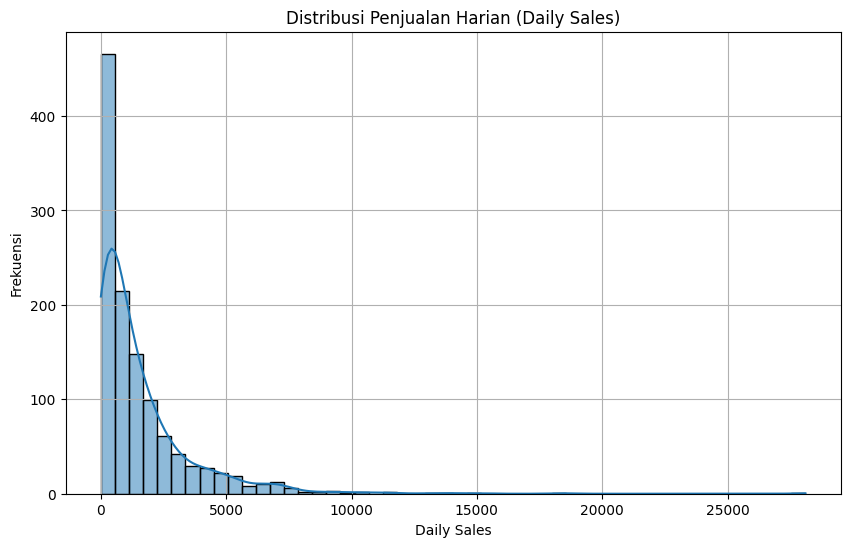

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(daily_data['daily_sales'], bins=50, kde=True)
plt.title('Distribusi Penjualan Harian (Daily Sales)')
plt.xlabel('Daily Sales')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

In [ ]:
print(daily_data.describe())

        daily_sales  daily_quantity  daily_order_count
count   1181.000000      1181.00000        1181.000000
mean    1556.805819        25.65199           3.354784
std     2102.959335        21.75203           2.375786
min        2.025000         1.00000           1.000000
25%      264.460000         9.00000           2.000000
50%      877.156000        20.00000           3.000000
75%     1995.198000        36.00000           4.000000
max    28106.716000       141.00000          18.000000


In [ ]:
daily_data['dayofweek'] = daily_data.index.dayofweek
# Mapping nama hari untuk visualisasi
day_mapping = {0: 'Senin', 1: 'Selasa', 2: 'Rabu', 3: 'Kamis', 4: 'Jumat', 5: 'Sabtu', 6: 'Minggu'}
daily_data['day_name'] = daily_data['dayofweek'].map(day_mapping)

# Agregasi penjualan dan jumlah order per hari dalam seminggu
dayofweek_sales = daily_data.groupby('day_name')[['daily_sales', 'daily_order_count']].mean().reindex(
    ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu']
)
print("\nRata-rata Penjualan dan Jumlah Order per Hari dalam Seminggu:")
print(dayofweek_sales)


Rata-rata Penjualan dan Jumlah Order per Hari dalam Seminggu:
          daily_sales  daily_order_count
day_name                                
Senin     1817.668259           3.833333
Selasa    1400.240142           2.633540
Rabu       732.551691           1.477778
Kamis     1523.452977           3.751634
Jumat     1779.698213           3.730570
Sabtu     1481.151507           3.447761
Minggu    1696.049937           3.570681


In [ ]:
# Identifikasi hari tersibuk
busiest_day_sales = dayofweek_sales['daily_sales'].idxmax()
busiest_day_orders = dayofweek_sales['daily_order_count'].idxmax()
print(f"\nHari dengan Penjualan Tertinggi: {busiest_day_sales}")
print(f"Hari dengan Jumlah Order Tertinggi: {busiest_day_orders}")


Hari dengan Penjualan Tertinggi: Senin
Hari dengan Jumlah Order Tertinggi: Senin


# 4. Analisis Tren dan Pola

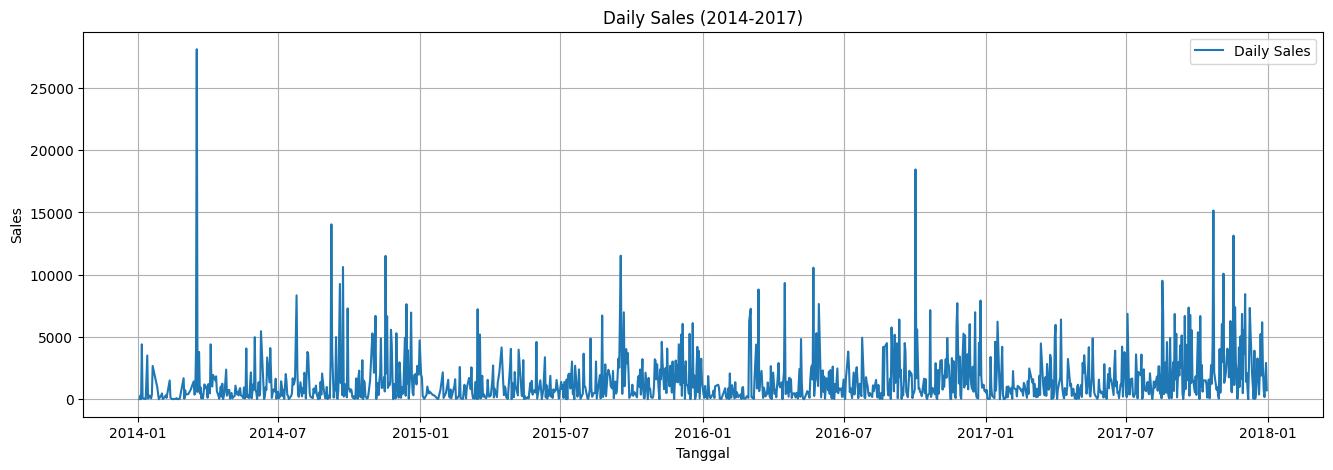

In [ ]:
# Plot daily sales
plt.figure(figsize=(16, 5))
plt.plot(daily_data['daily_sales'], label='Daily Sales')
plt.title('Daily Sales (2014-2017)')
plt.xlabel('Tanggal')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

Dari plot "Daily Sales (2014–2017)", terlihat bahwa penjualan bersifat sangat fluktuatif dan tidak menunjukkan tren kenaikan atau penurunan yang stabil dalam jangka panjang. Lonjakan-lonjakan tajam pada penjualan harian muncul secara sporadis sepanjang tahun, yang kemungkinan besar disebabkan oleh event khusus, diskon besar, kampanye promosi, atau pembelian dalam jumlah besar oleh pelanggan tertentu.

Beberapa titik ekstrem, seperti pada awal tahun 2014, pertengahan 2015, awal 2016, dan paruh kedua 2017, memperlihatkan outlier dengan nilai penjualan yang jauh lebih tinggi dibanding hari-hari lainnya. Ini bisa menjadi indikasi dari penjualan besar yang tidak rutin atau data anomali yang perlu dicermati lebih lanjut.

Polanya cenderung tidak beraturan, dengan noise harian yang tinggi, sehingga membuat pola musiman (seasonality) sulit untuk dikenali secara visual. Namun, karena fluktuasi tetap terjadi secara terus-menerus, ada kemungkinan terdapat pola mingguan atau bulanan yang berulang—yang dapat diungkap lebih dalam melalui analisis dekomposisi time series.

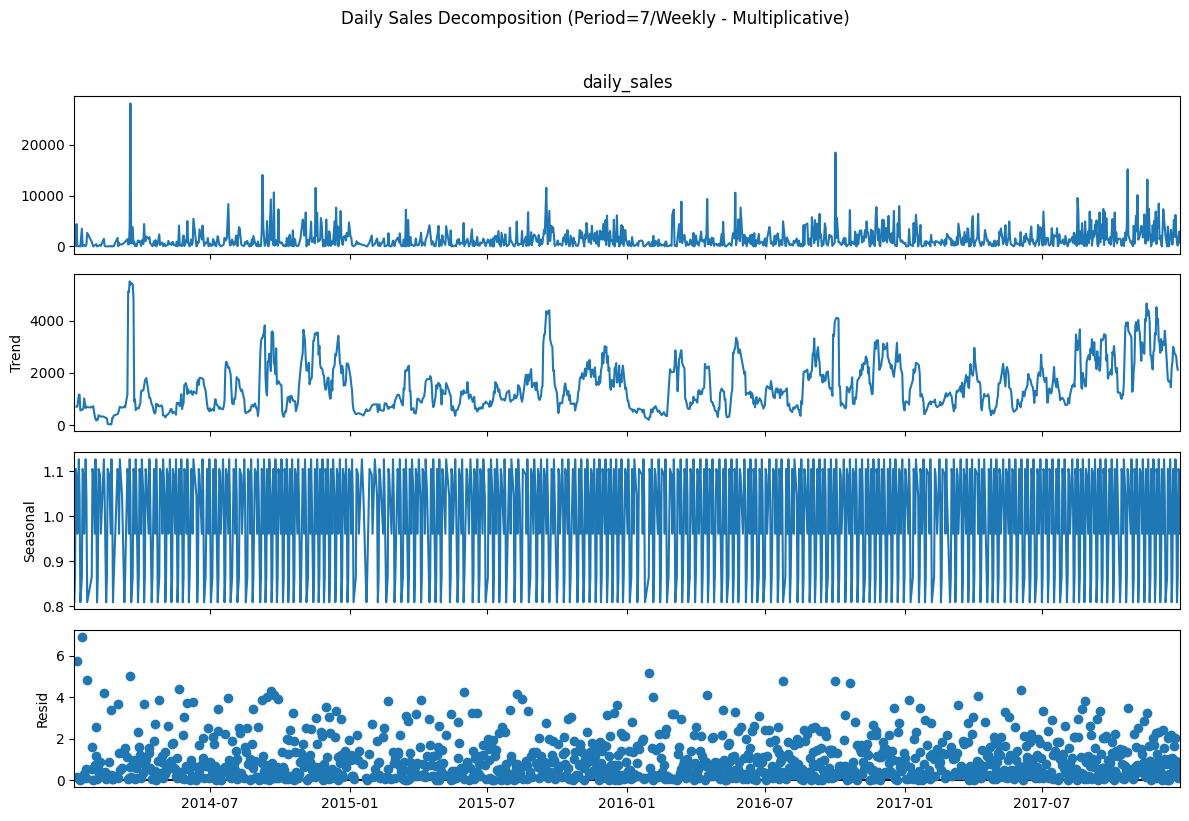

In [ ]:
# Dekomposisi musiman (mingguan dan bulanan)
decompose_weekly = seasonal_decompose(daily_data['daily_sales'], model='multiplicative', period=7)
decompose_monthly = seasonal_decompose(daily_data['daily_sales'], model='multiplicative', period=30)
decompose_weekly.plot().set_size_inches(12, 8)
plt.suptitle('Daily Sales Decomposition (Period=7/Weekly - Multiplicative)', y=1.02)
plt.tight_layout()
plt.show()

**Interpretasi Dekomposisi Time Series (Period = 7 Hari)**

Trend

Komponen trend menunjukkan arah umum dari penjualan harian dalam jangka panjang. Terlihat bahwa penjualan mengalami fluktuasi dengan pola peningkatan bertahap dari tahun 2014 hingga 2017, meskipun tidak stabil sepenuhnya. Terdapat periode lonjakan signifikan, terutama pada tahun 2015 dan 2017, yang kemungkinan berkaitan dengan promosi besar, kampanye musiman, atau event khusus. Secara keseluruhan, trend ini mencerminkan adanya pertumbuhan aktivitas penjualan dari waktu ke waktu.

Seasonal

Komponen seasonal mengungkap adanya pola musiman yang berulang setiap 7 hari, yang mengindikasikan pola mingguan. Pola ini konsisten sepanjang rentang waktu, dengan nilai yang berfluktuasi secara periodik antara 0.8 hingga 1.1. Hal ini menunjukkan bahwa terdapat hari-hari tertentu dalam seminggu yang secara konsisten menunjukkan tingkat penjualan lebih tinggi, kemungkinan karena perilaku konsumen yang berbelanja lebih banyak pada hari tertentu seperti akhir pekan.

Residual

Komponen residual menggambarkan variasi acak atau sisa yang tidak dapat dijelaskan oleh trend dan seasonal. Titik-titik residual tersebar merata dan tidak menunjukkan pola sistematis, yang berarti sebagian besar fluktuasi telah dijelaskan oleh dua komponen sebelumnya. Namun, terdapat beberapa nilai residual yang tinggi, mengindikasikan adanya kejadian tak terduga seperti flash sale, kampanye mendadak, atau anomali dalam data.

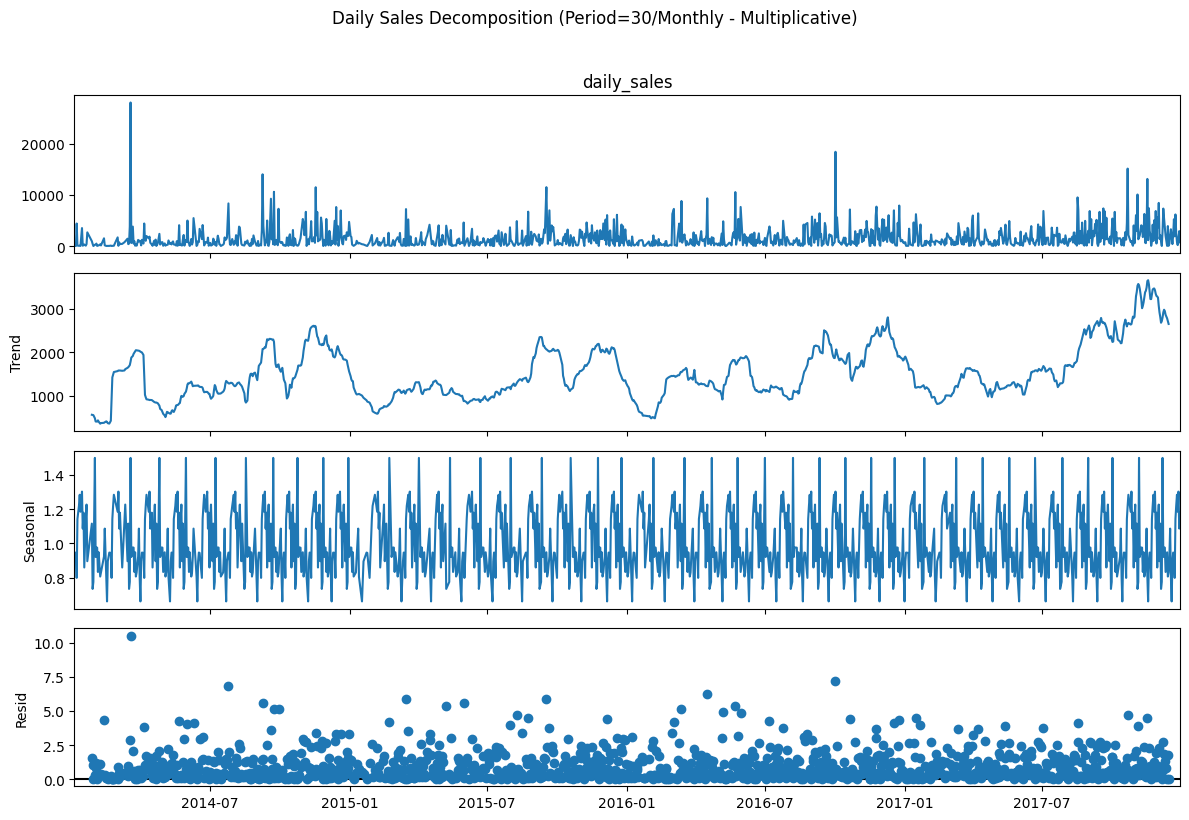

In [ ]:
decompose_monthly.plot().set_size_inches(12, 8)
plt.suptitle('Daily Sales Decomposition (Period=30/Monthly - Multiplicative)', y=1.02)
plt.tight_layout()
plt.show()

**Period = 30 (Monthly)**

Trend

Tren penjualan harian menunjukkan pertumbuhan bertahap yang cukup jelas dari tahun 2014 hingga akhir 2017. Walaupun terdapat beberapa fluktuasi naik-turun, arah umum dari garis tren cenderung meningkat, terutama setelah pertengahan 2016 hingga puncaknya menjelang akhir 2017. Hal ini mengindikasikan adanya perkembangan positif dalam bisnis, kemungkinan karena peningkatan jumlah pelanggan, perbaikan strategi pemasaran, atau pertumbuhan pasar secara umum.

Seasonal

Komponen seasonal memperlihatkan pola musiman yang stabil dan berulang dengan periode sekitar 30 hari (bulanan). Pola ini menunjukkan adanya kecenderungan perilaku konsumen dalam berbelanja secara periodik, seperti peningkatan aktivitas belanja di awal atau akhir bulan. Nilai seasonal bergerak antara 0.8 hingga 1.4, yang berarti efek musiman cukup signifikan terhadap total penjualan bulanan.

Residual

Komponen residual menggambarkan variasi atau noise yang tidak dijelaskan oleh trend dan seasonal. Titik-titik residual tersebar merata, namun terdapat sejumlah lonjakan (outlier) terutama pada pertengahan 2015 dan awal 2016. Hal ini menunjukkan adanya peristiwa tidak terduga seperti promo besar, event musiman, atau anomali data. Namun, secara keseluruhan, model dekomposisi telah mampu menangkap struktur utama dari data penjualan.

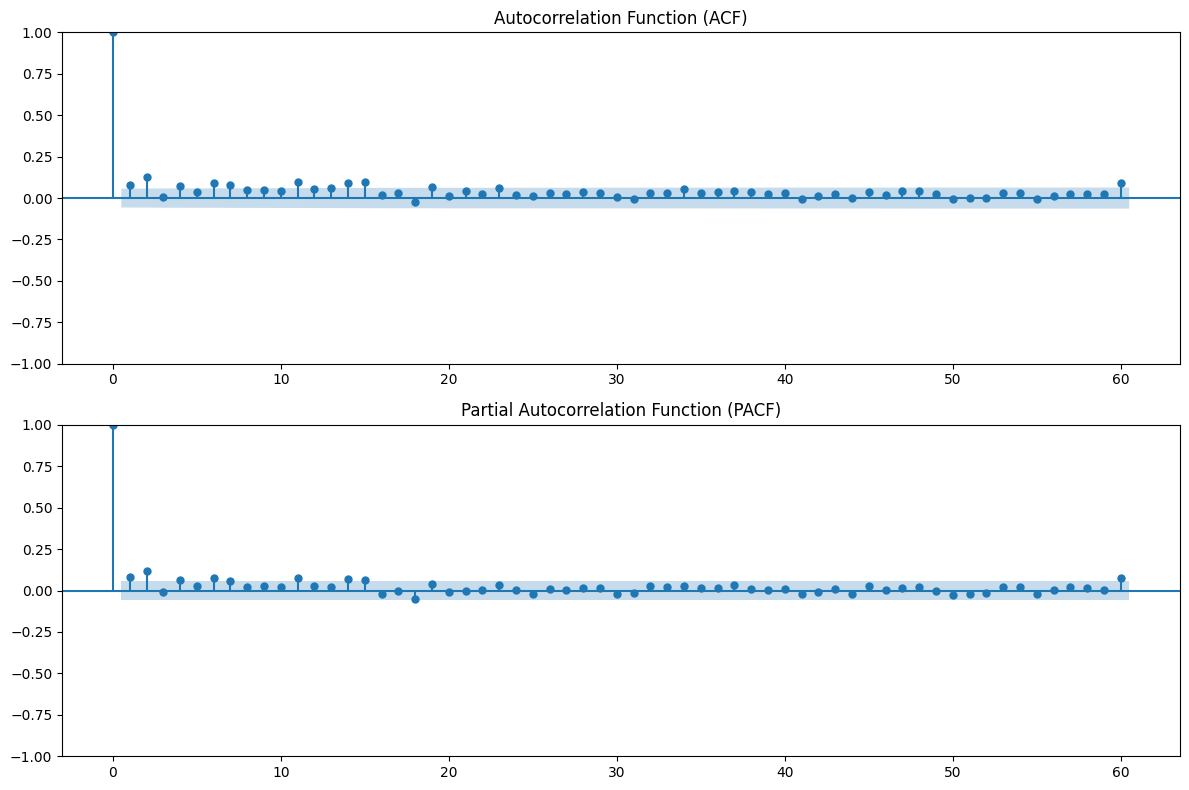

In [ ]:
# Plot ACF dan PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(daily_data['daily_sales'], lags=60, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_data['daily_sales'], lags=60, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

Autocorrelation Function (ACF)
- Lag 1–3: Nilai ACF masih menunjukkan korelasi positif yang cukup tinggi dan menurun secara bertahap, yang menandakan adanya efek autokorelasi jangka pendek. Ini berarti nilai penjualan saat ini masih dipengaruhi oleh 1 hingga 3 hari sebelumnya.

- Lag mingguan (7, 14, 21, dst.): Tidak terlihat lonjakan signifikan pada lag kelipatan 7, sehingga tidak ada indikasi pola musiman mingguan yang kuat.

- Pola peluruhan bertahap: ACF menurun secara bertahap ke nol, yang menunjukkan bahwa data masih mengandung tren dan kemungkinan besar belum sepenuhnya stasioner. Hal ini mendukung perlunya dilakukan differencing (d > 0) dalam model ARIMA.

Partial Autocorrelation Function (PACF)

- Lag 1: Nilai PACF sangat tinggi pada lag ke-1 dan langsung menurun drastis pada lag ke-2 dan seterusnya.

- Lag > 1: Nilai PACF berada dalam batas ketidak-signifikanan statistik, mendekati nol.

- Pola ini merupakan karakteristik khas dari proses AR(1) — yaitu model autoregressive orde 1, di mana hanya satu lag sebelumnya yang memiliki pengaruh signifikan terhadap nilai saat ini.

Implikasi Model

- Berdasarkan pola ACF dan PACF, model ARIMA(1, d, 0) merupakan titik awal yang baik untuk proses pemodelan. Nilai d (differencing) perlu ditentukan setelah pengujian stasioneritas, misalnya menggunakan Augmented Dickey-Fuller (ADF) Test.

- Jika hasil uji ADF menunjukkan bahwa data belum stasioner, maka minimal d = 1 akan diperlukan.


Penjualan Bulanan per Tahun:
 Order Date          1          2           3           4           5   \
Order Date                                                              
2014        13972.1410   3019.808  49351.6230  22280.7450  17434.7090   
2015        10347.0176  10920.241  29418.7580  31146.1590  22779.0545   
2016        10292.9830  10028.721  44617.7620  32348.4650  50677.1620   
2017        29873.8980  16258.344  35966.1898  31611.7931  32956.1588   

Order Date          6          7           8           9           10  \
Order Date                                                              
2014        30503.4916  27592.300  22072.1885  67442.9298  26895.5510   
2015        16167.4340  27965.625  29096.3260  56681.3810  24815.0925   
2016        24975.2510  32573.451  25620.1618  57913.6219  49614.5410   
2017        38084.0865  37400.334  51782.5040  74445.9850  61443.2092   

Order Date           11          12  
Order Date                           
2014         68

<Figure size 1200x1000 with 0 Axes>

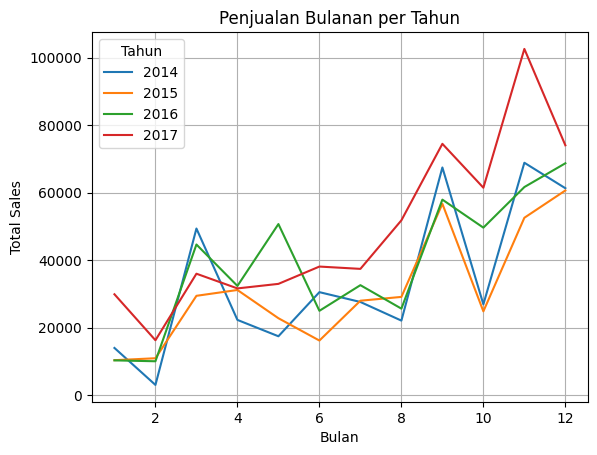

In [ ]:
# Analisis pola bulanan per tahun
monthly_sales = df.resample('M')['Sales'].sum()
yearly_monthly_sales = df.groupby([df.index.year, df.index.month])['Sales'].sum().unstack()
print("\nPenjualan Bulanan per Tahun:\n", yearly_monthly_sales)
plt.figure(figsize=(12, 10))
yearly_monthly_sales.T.plot()
plt.title('Penjualan Bulanan per Tahun')
plt.xlabel('Bulan')
plt.ylabel('Total Sales')
plt.legend(title='Tahun')
plt.grid(True)
plt.show()

In [ ]:
# Bulan tertinggi dan terendah
high_months = yearly_monthly_sales.idxmax(axis=1)
low_months = yearly_monthly_sales.idxmin(axis=1)
print("\nBulan dengan Penjualan Tertinggi per Tahun:\n", high_months)
print("\nBulan dengan Penjualan Terendah per Tahun:\n", low_months)


Bulan dengan Penjualan Tertinggi per Tahun:
 Order Date
2014    11
2015    12
2016    12
2017    11
dtype: int32

Bulan dengan Penjualan Terendah per Tahun:
 Order Date
2014    2
2015    1
2016    2
2017    2
dtype: int32


In [ ]:
trend = decompose_monthly.trend.dropna()
trend_slope = (trend.iloc[-1] - trend.iloc[0]) / len(trend)
trend_status = "meningkat" if trend_slope > 0 else "menurun" if trend_slope < 0 else "stagnan"
print(f"\nTren Penjualan Secara Umum: {trend_status}")


Tren Penjualan Secara Umum: meningkat


# 5. Analisis Metrik 2017

In [ ]:
df_2017 = df[df.index.year == 2017]
total_revenue_2017 = df_2017['Sales'].sum()
total_orders_2017 = df_2017['Order ID'].nunique()
total_quantity_2017 = df_2017['Quantity'].sum()
avg_quantity_per_order = total_quantity_2017 / total_orders_2017
avg_spending_per_order = total_revenue_2017 / total_orders_2017

In [ ]:
print("\n--- METRIK TAHUN 2017 ---")
print(f"Total Revenue (2017): ${total_revenue_2017:,.2f}")
print(f"Total Orders (2017): {total_orders_2017}")
print(f"Total Quantity Sold (2017): {total_quantity_2017}")
print(f"Rata-rata Barang per Transaksi (2017): {avg_quantity_per_order:.2f}")
print(f"Rata-rata Spending per Transaksi (2017): ${avg_spending_per_order:.2f}")


--- METRIK TAHUN 2017 ---
Total Revenue (2017): $586,394.42
Total Orders (2017): 1341
Total Quantity Sold (2017): 10085
Rata-rata Barang per Transaksi (2017): 7.52
Rata-rata Spending per Transaksi (2017): $437.28


# 6. GMV dan Jumlah Order (Harian, Mingguan, Bulanan)

In [ ]:
weekly_data = daily_data.resample('W').agg({
    'daily_sales': 'sum',
    'daily_order_count': 'sum'
}).rename(columns={'daily_sales': 'weekly_gmv', 'daily_order_count': 'weekly_orders'})
monthly_data = daily_data.resample('M').agg({
    'daily_sales': 'sum',
    'daily_order_count': 'sum'
}).rename(columns={'daily_sales': 'monthly_gmv', 'daily_order_count': 'monthly_orders'})

print("\nHarian GMV dan Orders (5 baris pertama):\n", daily_data[['daily_sales', 'daily_order_count']].head())
print("\nMingguan GMV dan Orders (5 baris pertama):\n", weekly_data.head())
print("\nBulanan GMV dan Orders (5 baris pertama):\n", monthly_data.head())


Harian GMV dan Orders (5 baris pertama):
             daily_sales  daily_order_count
Order Date                                
2014-01-03       16.448                  1
2014-01-04      288.060                  1
2014-01-05       19.536                  1
2014-01-06     4407.100                  3
2014-01-07       87.158                  1

Mingguan GMV dan Orders (5 baris pertama):
             weekly_gmv  weekly_orders
Order Date                           
2014-01-05     324.044              3
2014-01-12    4599.572              7
2014-01-19    4468.281              8
2014-01-26    3618.480              5
2014-02-02    1443.014              6

Bulanan GMV dan Orders (5 baris pertama):
             monthly_gmv  monthly_orders
Order Date                             
2014-01-31    13972.141              27
2014-02-28     3019.808              17
2014-03-31    49351.623              54
2014-04-30    22280.745              51
2014-05-31    17434.709              56


# 7. Analisis Produk dan Bundling

In [ ]:
last_3_months = df[df.index >= df.index.max() - pd.Timedelta(days=90)]
top_products = last_3_months.groupby('Product Name')['Sales'].sum().nlargest(10)
print("\nTop 10 Produk (Revenue, 3 Bulan Terakhir):\n", top_products)


Top 10 Produk (Revenue, 3 Bulan Terakhir):
 Product Name
Canon imageCLASS 2200 Advanced Copier               21699.938
Cubify CubeX 3D Printer Triple Head Print            7999.980
3D Systems Cube Printer, 2nd Generation, Magenta     5199.960
Adjustable Depth Letter/Legal Cart                   4028.412
Hewlett Packard LaserJet 3310 Copier                 2879.952
Tennsco Double-Tier Lockers                          2835.252
Hon 94000 Series Round Tables                        2665.620
Hoover Shoulder Vac Commercial Portable Vacuum       2504.740
Hon GuestStacker Chair                               2493.370
ClearOne CHATAttach 160 - speaker phone              2479.960
Name: Sales, dtype: float64


In [ ]:
from itertools import combinations
# Rekomendasi bundling berdasarkan co-occurrence
order_baskets = last_3_months.groupby('Order ID')['Product Name'].apply(list)
product_pairs = order_baskets.apply(lambda x: list(combinations(x, 2)))
pair_counts = pd.Series([pair for sublist in product_pairs for pair in sublist]).value_counts().head(10)
print("\nRekomendasi Bundling (Pasangan Produk):\n", pair_counts)


Rekomendasi Bundling (Pasangan Produk):
 (Eldon Image Series Desk Accessories, Burgundy, Memorex Micro Travel Drive 16 GB)                 2
(Wirebound Four 2-3/4 x 5 Forms per Page, 400 Sets per Book, Memorex Micro Travel Drive 16 GB)    2
(Staple-based wall hangings, Memorex Micro Travel Drive 16 GB)                                    2
(Maxell iVDR EX 500GB Cartridge, Adjustable Depth Letter/Legal Cart)                              2
(Memorex Micro Travel Drive 16 GB, Newell 344)                                                    2
(Elite 5" Scissors, Memorex Micro Travel Drive 16 GB)                                             2
(Memorex Micro Travel Drive 16 GB, DAX Two-Tone Silver Metal Document Frame)                      2
(Hon Every-Day Series Multi-Task Chairs, Personal Creations Ink Jet Cards and Labels)             1
(Hon Every-Day Series Multi-Task Chairs, GBC White Gloss Covers, Plain Front)                     1
(Hon Every-Day Series Multi-Task Chairs, Xerox 222)       

# 8. Analisis Kota

In [ ]:
city_orders = df.groupby('City')['Order ID'].nunique().nlargest(5)
city_spending = df.groupby('City')['Sales'].agg(['sum', 'mean']).nlargest(5, 'sum')
print("\nTop 5 Kota (Jumlah Order):\n", city_orders)
print("\nTop 5 Kota (Total dan Rata-rata Spending):\n", city_spending)


Top 5 Kota (Jumlah Order):
 City
New York City    362
Los Angeles      306
Philadelphia     209
San Francisco    208
Seattle          170
Name: Order ID, dtype: int64

Top 5 Kota (Total dan Rata-rata Spending):
                        sum        mean
City                                  
New York City  204298.5330  274.964378
Los Angeles    136767.6765  229.475967
San Francisco   94433.9760  226.460374
Philadelphia    89027.4830  200.964973
Seattle         82721.6980  246.195530


# 9. Feature Engineering

In [ ]:
def create_time_features(df_input):
    df_output = df_input.copy()
    df_output['year'] = df_output.index.year
    df_output['month'] = df_output.index.month
    df_output['day'] = df_output.index.day
    df_output['dayofweek'] = df_output.index.dayofweek
    df_output['dayofyear'] = df_output.index.dayofyear
    df_output['weekofyear'] = df_output.index.isocalendar().week.astype(int)
    df_output['quarter'] = df_output.index.quarter
    df_output['is_weekend'] = (df_output.index.dayofweek >= 5).astype(int)
    df_output['dayofweek_sin'] = np.sin(2 * np.pi * df_output['dayofweek'] / 7)
    df_output['dayofweek_cos'] = np.cos(2 * np.pi * df_output['dayofweek'] / 7)
    df_output['dayofyear_sin'] = np.sin(2 * np.pi * df_output['dayofyear'] / 365)
    df_output['dayofyear_cos'] = np.cos(2 * np.pi * df_output['dayofyear'] / 365)
    df_output['month_sin'] = np.sin(2 * np.pi * df_output['month'] / 12)
    df_output['month_cos'] = np.cos(2 * np.pi * df_output['month'] / 12)
    return df_output

def create_lag_rolling_features(df_input, target_col):
    df_temp = df_input.copy()
    df_temp[f'{target_col}_lag_1'] = df_temp[target_col].shift(1)
    df_temp[f'{target_col}_lag_7'] = df_temp[target_col].shift(7)
    df_temp[f'{target_col}_rolling_mean_7'] = df_temp[target_col].rolling(window=7, min_periods=1).mean()
    df_temp[f'{target_col}_rolling_std_7'] = df_temp[target_col].rolling(window=7, min_periods=1).std()
    df_temp[f'{target_col}_rolling_mean_30'] = df_temp[target_col].rolling(window=30, min_periods=1).mean()
    return df_temp

# Terapkan feature engineering
df_features = create_time_features(daily_data)
for target in ['daily_sales', 'daily_order_count']:
    df_features = create_lag_rolling_features(df_features, target)

# Isi NaN dengan mean
for col in df_features.columns:
    if df_features[col].isnull().any():
        df_features[col].fillna(df_features[col].mean(), inplace=True)

print(f"\nUkuran Data Setelah Feature Engineering: {df_features.shape[0]} baris")


Ukuran Data Setelah Feature Engineering: 1181 baris


# 10. Split Data

In [ ]:
test_size_days = 365  # 1 bulan
split_date = df_features.index.max() - pd.Timedelta(days=test_size_days)

# Fitur untuk model ML
ml_features = [col for col in df_features.columns if col not in ['daily_sales', 'daily_order_count', 'day_name']]
X_train_ml = df_features[df_features.index <= split_date][ml_features]
X_test_ml = df_features[df_features.index > split_date][ml_features]
y_train_sales = df_features[df_features.index <= split_date]['daily_sales']
y_test_sales = df_features[df_features.index > split_date]['daily_sales']
y_train_orders = df_features[df_features.index <= split_date]['daily_order_count']
y_test_orders = df_features[df_features.index > split_date]['daily_order_count']

# Fitur eksogen untuk model time series
exog_cols = [
    'daily_quantity', 'year', 'month', 'day', 'dayofweek', 'dayofyear',
    'weekofyear', 'quarter', 'is_weekend', 'dayofweek_sin', 'dayofweek_cos',
    'dayofyear_sin', 'dayofyear_cos', 'month_sin', 'month_cos', 'day_name'
]
exog_train = df_features[exog_cols][df_features.index <= split_date]
exog_test = df_features[exog_cols][df_features.index > split_date]

print(f"Ukuran Data Training ML: {len(X_train_ml)} hari")
print(f"Ukuran Data Testing ML: {len(X_test_ml)} hari")
print(f"Ukuran Data Training TS (Sales): {len(y_train_sales)} hari")
print(f"Ukuran Data Testing TS (Sales): {len(y_test_sales)} hari")
print(f"Ukuran Data Training TS (Orders): {len(y_train_orders)} hari")
print(f"Ukuran Data Testing TS (Orders): {len(y_test_orders)} hari")

Ukuran Data Training ML: 868 hari
Ukuran Data Testing ML: 313 hari
Ukuran Data Training TS (Sales): 868 hari
Ukuran Data Testing TS (Sales): 313 hari
Ukuran Data Training TS (Orders): 868 hari
Ukuran Data Testing TS (Orders): 313 hari


# 11. Evaluasi dan Plotting Fungsi

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    y_pred = np.maximum(0, y_pred)
    if isinstance(y_pred, np.ndarray):
        y_pred = pd.Series(y_pred, index=y_true.index)
    if not y_true.index.equals(y_pred.index):
        y_pred = y_pred.reindex(y_true.index)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    y_true_cleaned = y_true.replace(0, 1e-9)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_cleaned)[np.isfinite(np.abs((y_true - y_pred) / y_true_cleaned))]) * 100
    print(f"--- {model_name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    return rmse, mae, mape

def plot_predictions(y_true, y_pred, model_name, target_name):
    plt.figure(figsize=(15, 6))
    plt.plot(y_true.index, y_true, label='Aktual', color='blue')
    if isinstance(y_pred, np.ndarray):
        y_pred = pd.Series(y_pred, index=y_true.index)
    if not y_true.index.equals(y_pred.index):
        y_pred = y_pred.reindex(y_true.index)
    plt.plot(y_true.index, y_pred, label=f'Prediksi {model_name}', color='red', linestyle='--', alpha=0.7)
    plt.title(f'Prediksi {model_name} vs Aktual ({target_name})')
    plt.xlabel('Tanggal')
    plt.ylabel(target_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 12. Forecasting untuk Daily Sales

--- Naive Forecast (Sales) ---
RMSE: 2914.8104
MAE : 2027.0333
MAPE: 880.92%


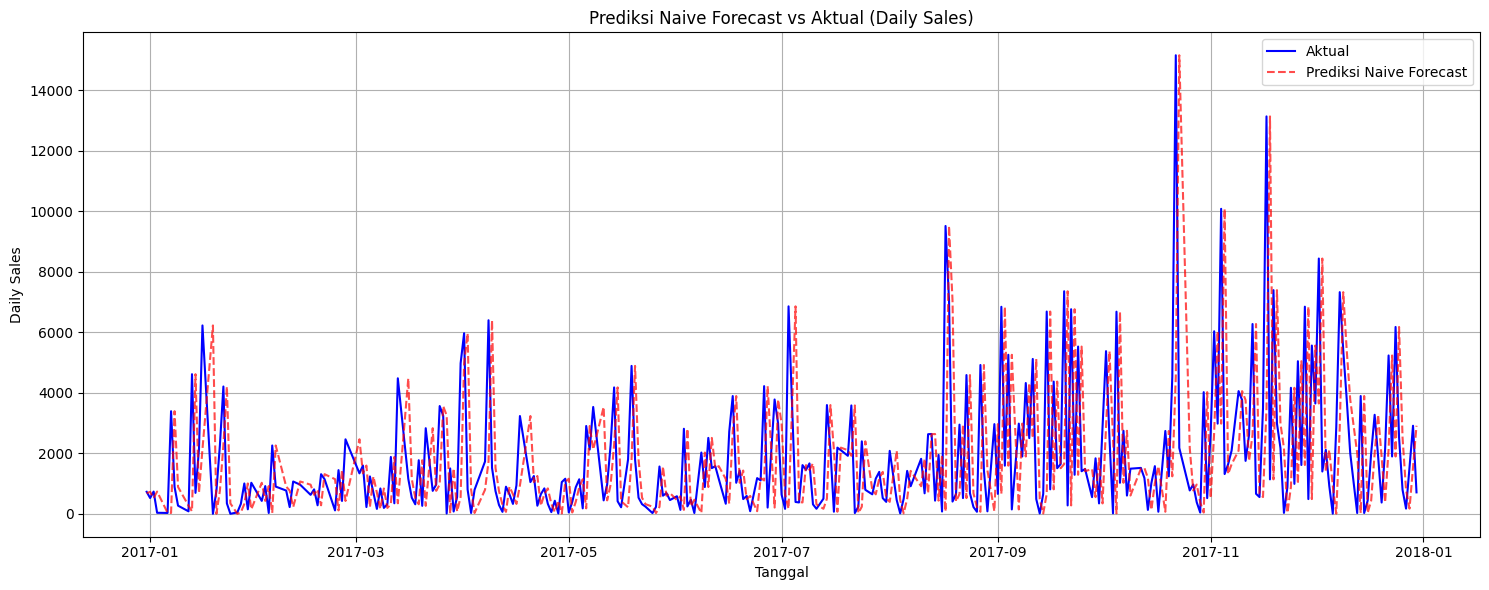

In [ ]:
results_sales = []
# Naive Forecast
y_pred_naive_sales = y_test_sales.shift(1)
y_pred_naive_sales.iloc[0] = y_train_sales.iloc[-1]
rmse, mae, mape = evaluate_model(y_test_sales, y_pred_naive_sales, "Naive Forecast (Sales)")
plot_predictions(y_test_sales, y_pred_naive_sales, "Naive Forecast", "Daily Sales")
results_sales.append(['Naive', rmse, mae, mape])

--- Holt-Winters (Sales) ---
RMSE: 2832.8862
MAE : 1873.9529
MAPE: 292.48%


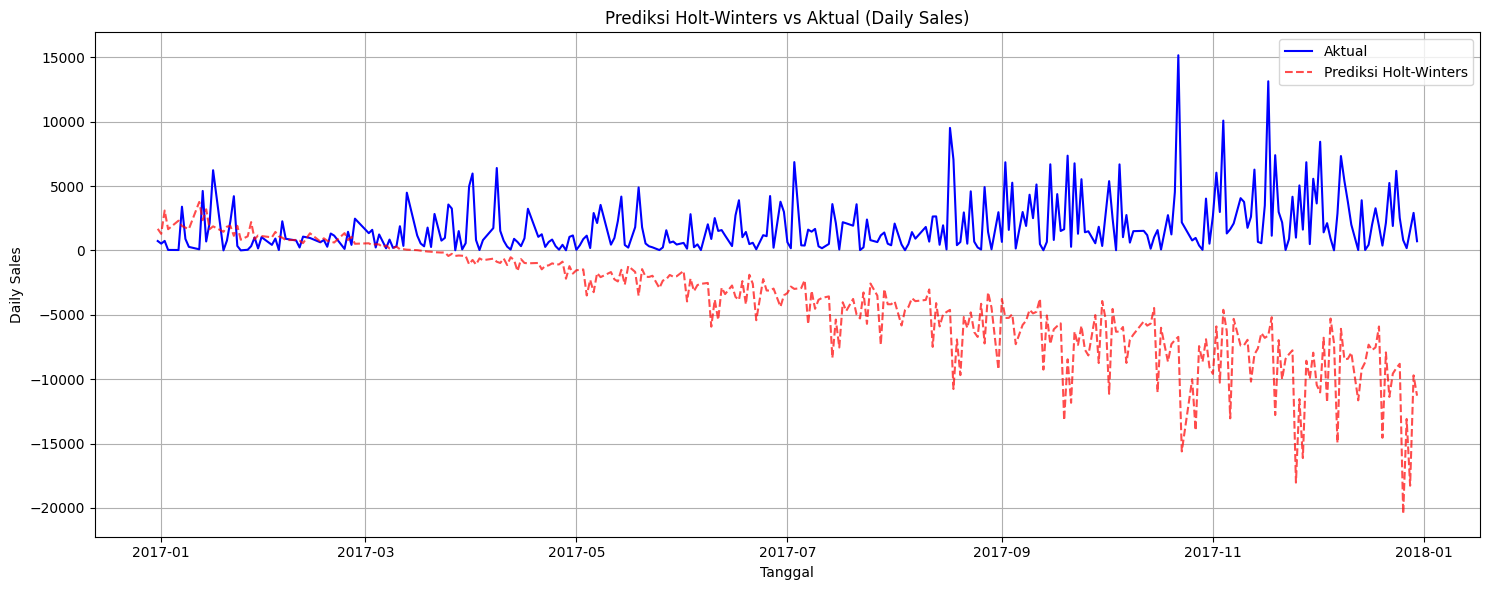

In [ ]:
# Holt-Winters
hw_model_sales = ExponentialSmoothing(
    y_train_sales, trend='add', seasonal='multiplicative', seasonal_periods=30
).fit()
y_pred_hw_sales = pd.Series(hw_model_sales.forecast(len(y_test_sales)).values, index=y_test_sales.index)
rmse, mae, mape = evaluate_model(y_test_sales, y_pred_hw_sales, "Holt-Winters (Sales)")
plot_predictions(y_test_sales, y_pred_hw_sales, "Holt-Winters", "Daily Sales")
results_sales.append(['Holt-Winters', rmse, mae, mape])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2646
[LightGBM] [Info] Number of data points in the train set: 868, number of used features: 25
[LightGBM] [Info] Start training from score 1441.775908
--- LightGBM (Sales) ---
RMSE: 1668.8191
MAE : 1128.0884
MAPE: 305.12%


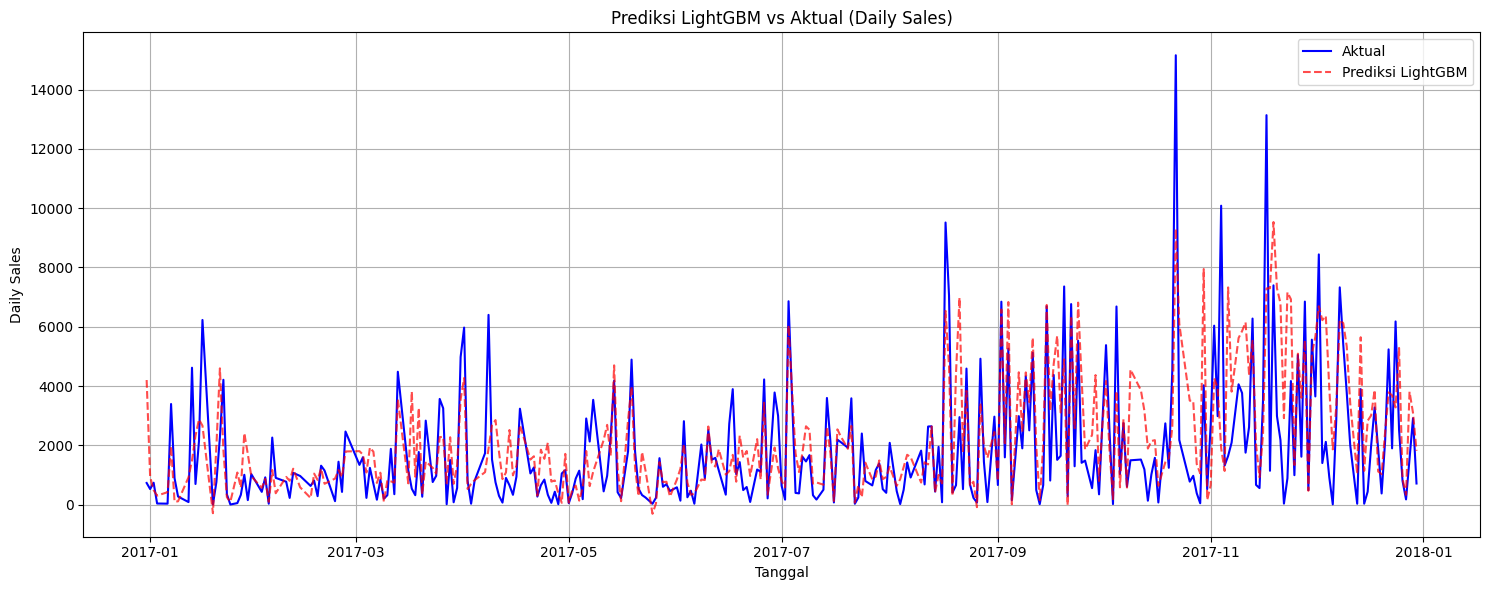

In [ ]:
# LightGBM
lgb_model_sales = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model_sales.fit(X_train_ml, y_train_sales)
y_pred_lgb_sales = lgb_model_sales.predict(X_test_ml)
rmse, mae, mape = evaluate_model(y_test_sales, y_pred_lgb_sales, "LightGBM (Sales)")
plot_predictions(y_test_sales, y_pred_lgb_sales, "LightGBM", "Daily Sales")
results_sales.append(['LightGBM', rmse, mae, mape])

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj8yavnkh/wfq4l3ce.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj8yavnkh/9c4gv6dl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32001', 'data', 'file=/tmp/tmpj8yavnkh/wfq4l3ce.json', 'init=/tmp/tmpj8yavnkh/9c4gv6dl.json', 'output', 'file=/tmp/tmpj8yavnkh/prophet_model88c1175n/prophet_model-20250620143431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:34:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:34:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Prophet (Sales) ---
RMSE: 1988.8184
MAE : 1314.0590
MAPE: 542.75%


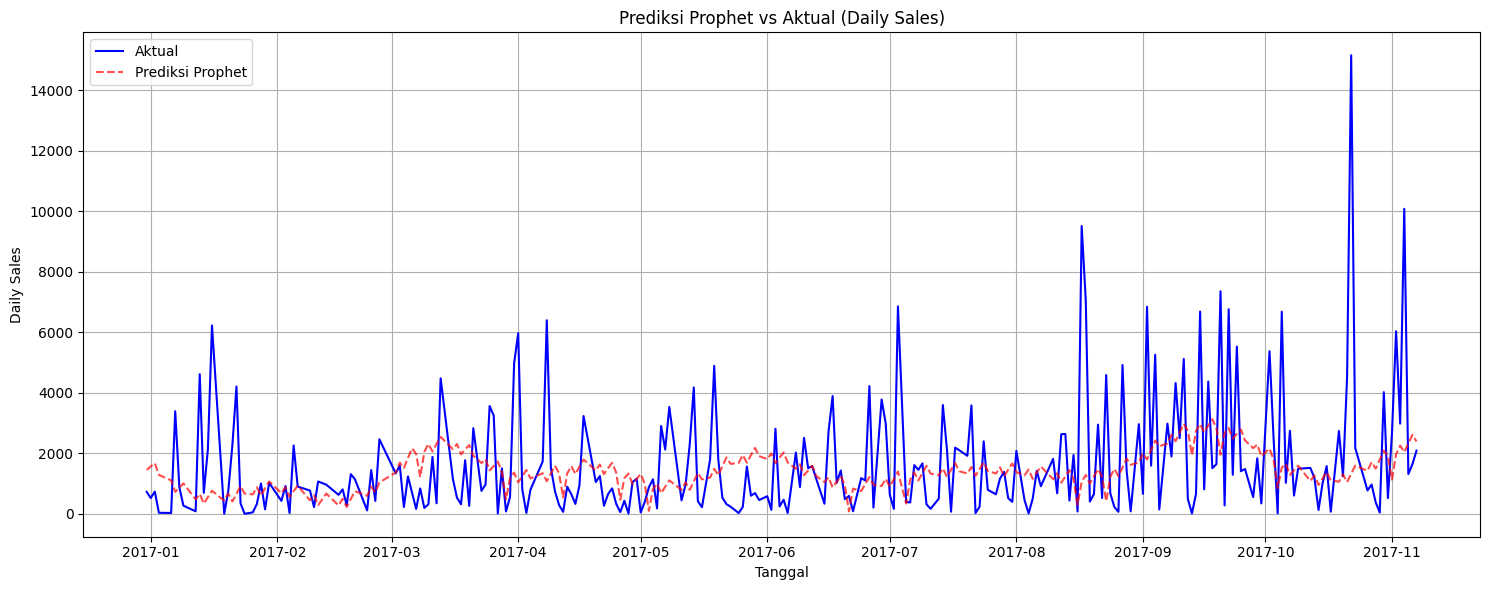

In [ ]:
# Prophet
df_prophet_sales = df_features[['daily_sales']].reset_index().rename(columns={
    'Order Date': 'ds', 'daily_sales': 'y'
})
train_prophet_sales = df_prophet_sales[df_prophet_sales['ds'] <= split_date]
test_prophet_sales = df_prophet_sales[df_prophet_sales['ds'] > split_date]
prophet_model_sales = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model_sales.fit(train_prophet_sales)
future_sales = prophet_model_sales.make_future_dataframe(periods=len(test_prophet_sales))
forecast_sales = prophet_model_sales.predict(future_sales)
y_pred_prophet_sales = forecast_sales[forecast_sales['ds'] > split_date][['ds', 'yhat']].set_index('ds')['yhat']
y_true_sales, y_pred_prophet_sales = test_prophet_sales.set_index('ds')['y'].align(y_pred_prophet_sales, join='inner')
rmse, mae, mape = evaluate_model(y_true_sales, y_pred_prophet_sales, "Prophet (Sales)")
plot_predictions(y_true_sales, y_pred_prophet_sales, "Prophet", "Daily Sales")
results_sales.append(['Prophet', rmse, mae, mape])

--- ARIMA(1,1,1) ---
RMSE: 2166.9193
MAE : 1647.7362
MAPE: 1023.79%


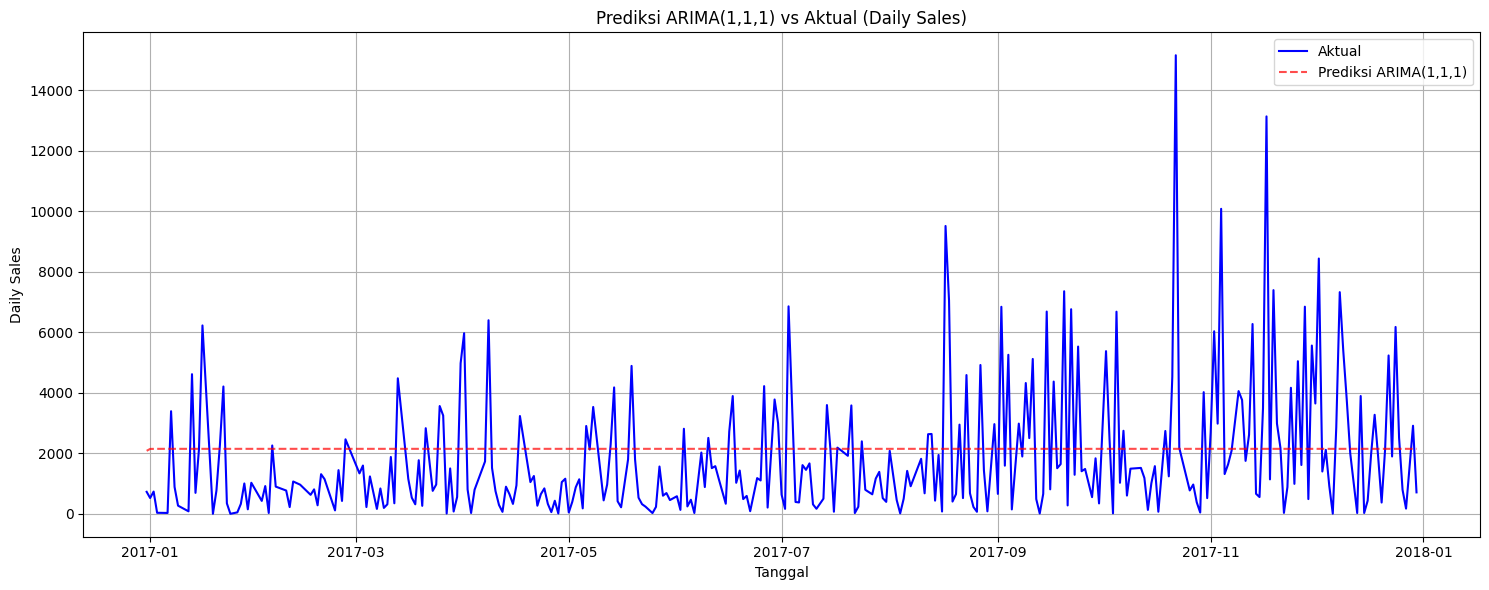

In [ ]:
# Model ARIMA (non-seasonal)
arima_model = ARIMA(y_train_sales, order=(1,1,1))
arima_fit = arima_model.fit()

# Forecasting
y_pred_arima_raw = arima_fit.forecast(steps=len(y_test_sales))

# Explicitly create a pandas Series with the correct index and fill NaNs
y_pred_arima = pd.Series(y_pred_arima_raw.values, index=y_test_sales.index)

# Ensure no NaNs remain by filling with 0 (or another appropriate strategy like ffill/bfill if preferred)
y_pred_arima = y_pred_arima.fillna(0)

# Evaluasi
# The evaluate_model function already handles aligning indices, but passing a Series with the correct index is best practice.
rmse, mae, mape = evaluate_model(y_test_sales, y_pred_arima, "ARIMA(1,1,1)")
plot_predictions(y_test_sales, y_pred_arima, "ARIMA(1,1,1)", "Daily Sales")

results_sales.append([
    'ARIMA(1,1,1)',
    rmse, mae, mape
])

--- XGBoost (Sales) ---
RMSE: 1829.8080
MAE : 1201.5019
MAPE: 308.56%


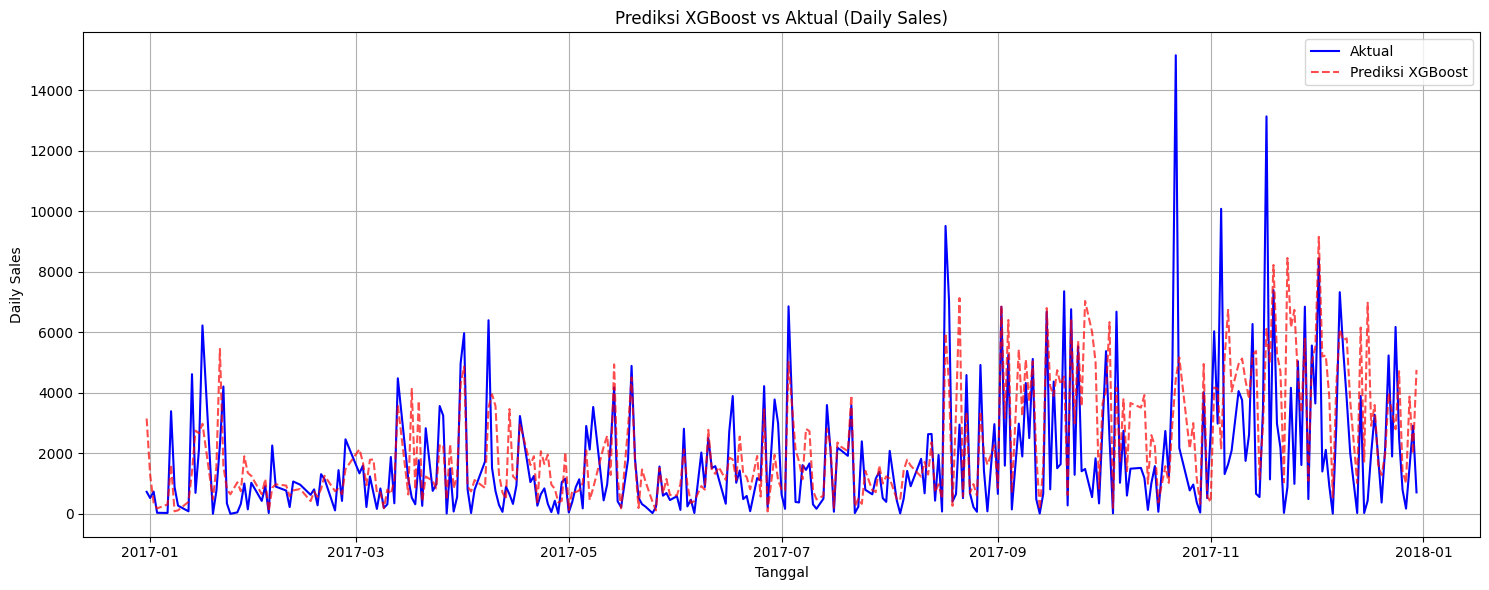

In [ ]:
# Model XGBoost
xgb_model_sales = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Training
xgb_model_sales.fit(X_train_ml, y_train_sales)

# Prediksi
y_pred_xgb_sales = xgb_model_sales.predict(X_test_ml)

# Evaluasi dan Visualisasi
rmse, mae, mape = evaluate_model(y_test_sales, y_pred_xgb_sales, "XGBoost (Sales)")
plot_predictions(y_test_sales, y_pred_xgb_sales, "XGBoost", "Daily Sales")

results_sales.append([
    'XGBoost',
    rmse, mae, mape
])

# 13. Forecasting untuk Daily Order Count

--- Naive Forecast (Orders) ---
RMSE: 3.3229
MAE : 2.5431
MAPE: 87.75%


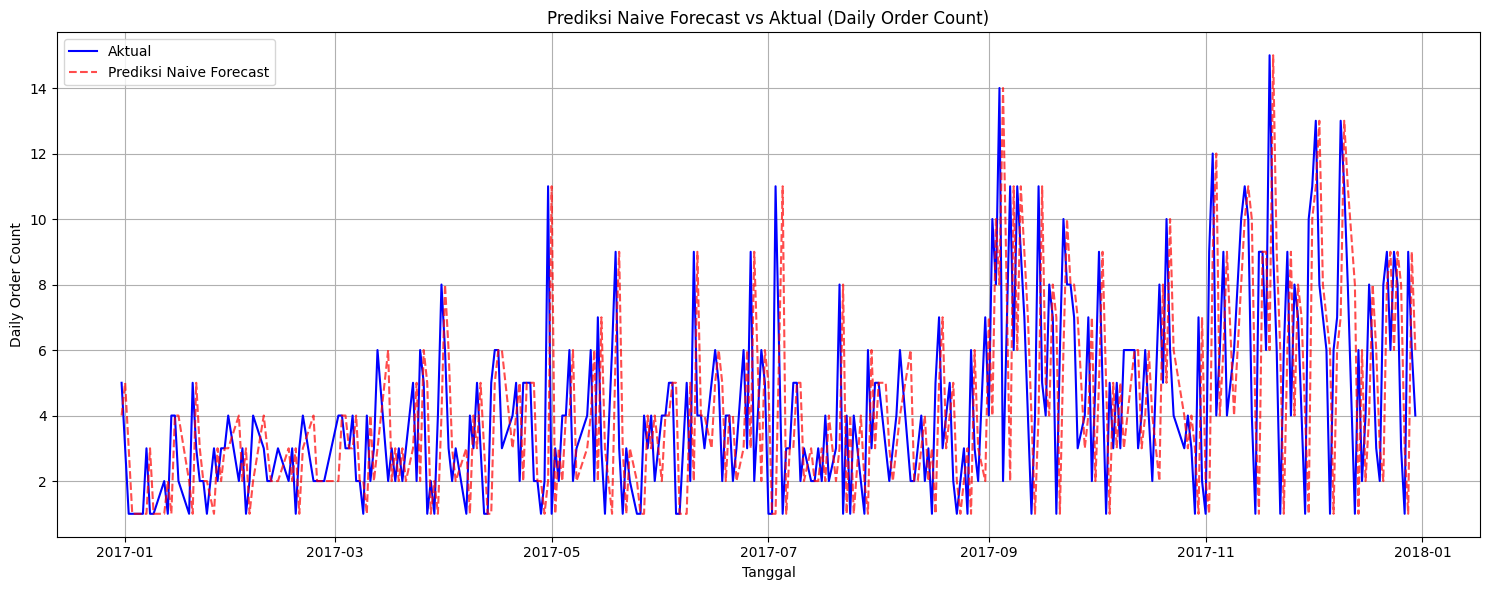

In [ ]:
results_orders = []
# Naive Forecast
y_pred_naive_orders = y_test_orders.shift(1)
y_pred_naive_orders.iloc[0] = y_train_orders.iloc[-1]
rmse, mae, mape = evaluate_model(y_test_orders, y_pred_naive_orders, "Naive Forecast (Orders)")
plot_predictions(y_test_orders, y_pred_naive_orders, "Naive Forecast", "Daily Order Count")
results_orders.append(['Naive', rmse, mae, mape])

--- Holt-Winters (Orders) ---
RMSE: 2.9505
MAE : 2.4819
MAPE: 111.52%


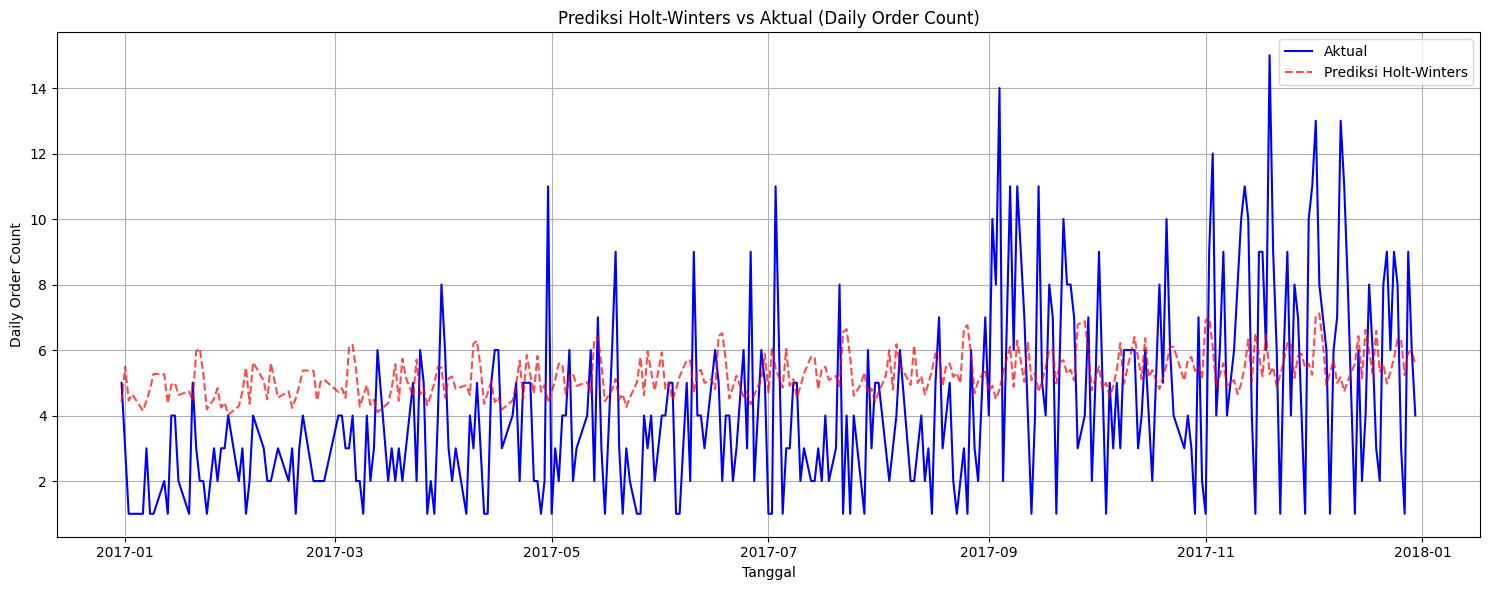

In [ ]:
# Holt-Winters
hw_model_orders = ExponentialSmoothing(
    y_train_orders, trend='add', seasonal='multiplicative', seasonal_periods=30
).fit()
y_pred_hw_orders = pd.Series(hw_model_orders.forecast(len(y_test_orders)).values, index=y_test_orders.index)
rmse, mae, mape = evaluate_model(y_test_orders, y_pred_hw_orders, "Holt-Winters (Orders)")
plot_predictions(y_test_orders, y_pred_hw_orders, "Holt-Winters", "Daily Order Count")
results_orders.append(['Holt-Winters', rmse, mae, mape])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2646
[LightGBM] [Info] Number of data points in the train set: 868, number of used features: 25
[LightGBM] [Info] Start training from score 3.013825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
--- LightGBM (Orders) ---
RMSE: 1.3537
MAE : 1.0188
MAPE: 33.24%


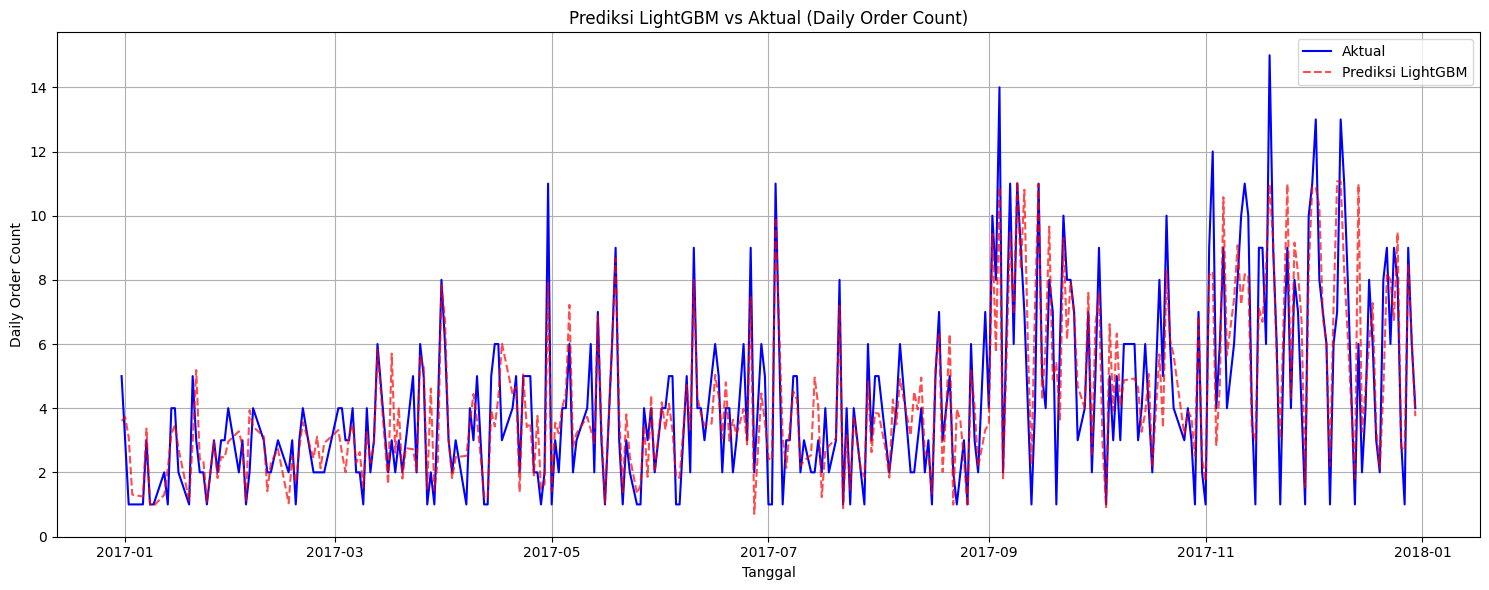

In [ ]:
# LightGBM
lgb_model_orders = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model_orders.fit(X_train_ml, y_train_orders)
y_pred_lgb_orders = lgb_model_orders.predict(X_test_ml)
rmse, mae, mape = evaluate_model(y_test_orders, y_pred_lgb_orders, "LightGBM (Orders)")
plot_predictions(y_test_orders, y_pred_lgb_orders, "LightGBM", "Daily Order Count")
results_orders.append(['LightGBM', rmse, mae, mape])

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

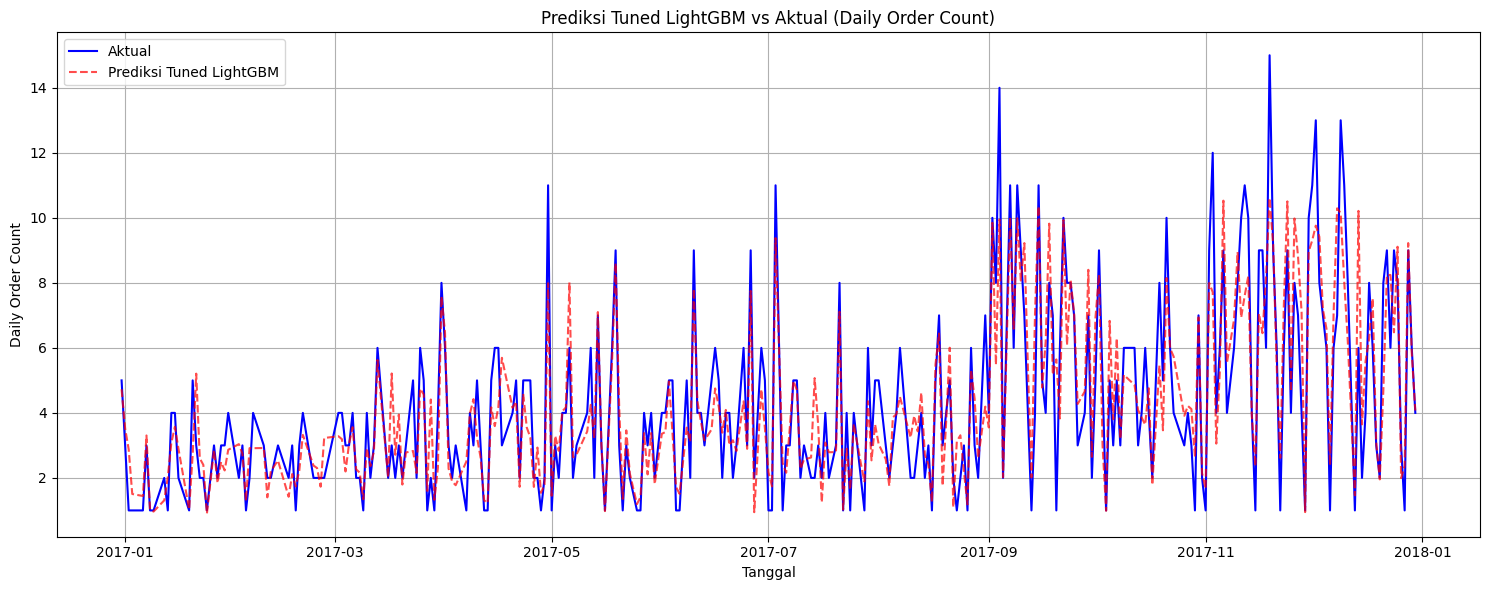

In [ ]:
param_grid_orders = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Inisialisasi model dan grid search
lgb_orders = lgb.LGBMRegressor(random_state=42)
grid_search_orders = GridSearchCV(
    lgb_orders,
    param_grid_orders,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1
)

# Fit ke data training
grid_search_orders.fit(X_train_ml, y_train_orders)

# Ambil model terbaik
best_lgb_orders = grid_search_orders.best_estimator_
print("Best Parameters for Orders:", grid_search_orders.best_params_)

# Prediksi dan evaluasi
y_pred_lgb_orders_tuned = best_lgb_orders.predict(X_test_ml)
rmse, mae, mape = evaluate_model(y_test_orders, y_pred_lgb_orders_tuned, "Tuned LightGBM (Orders)")
plot_predictions(y_test_orders, y_pred_lgb_orders_tuned, "Tuned LightGBM", "Daily Order Count")
results_orders.append(['Tuned LightGBM', rmse, mae, mape])

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj8yavnkh/mp6hkwck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj8yavnkh/_y3kuryi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41779', 'data', 'file=/tmp/tmpj8yavnkh/mp6hkwck.json', 'init=/tmp/tmpj8yavnkh/_y3kuryi.json', 'output', 'file=/tmp/tmpj8yavnkh/prophet_modelepcw6dt_/prophet_model-20250620143500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:35:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:35:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Prophet (Orders) ---
RMSE: 2.1079
MAE : 1.5883
MAPE: 60.38%


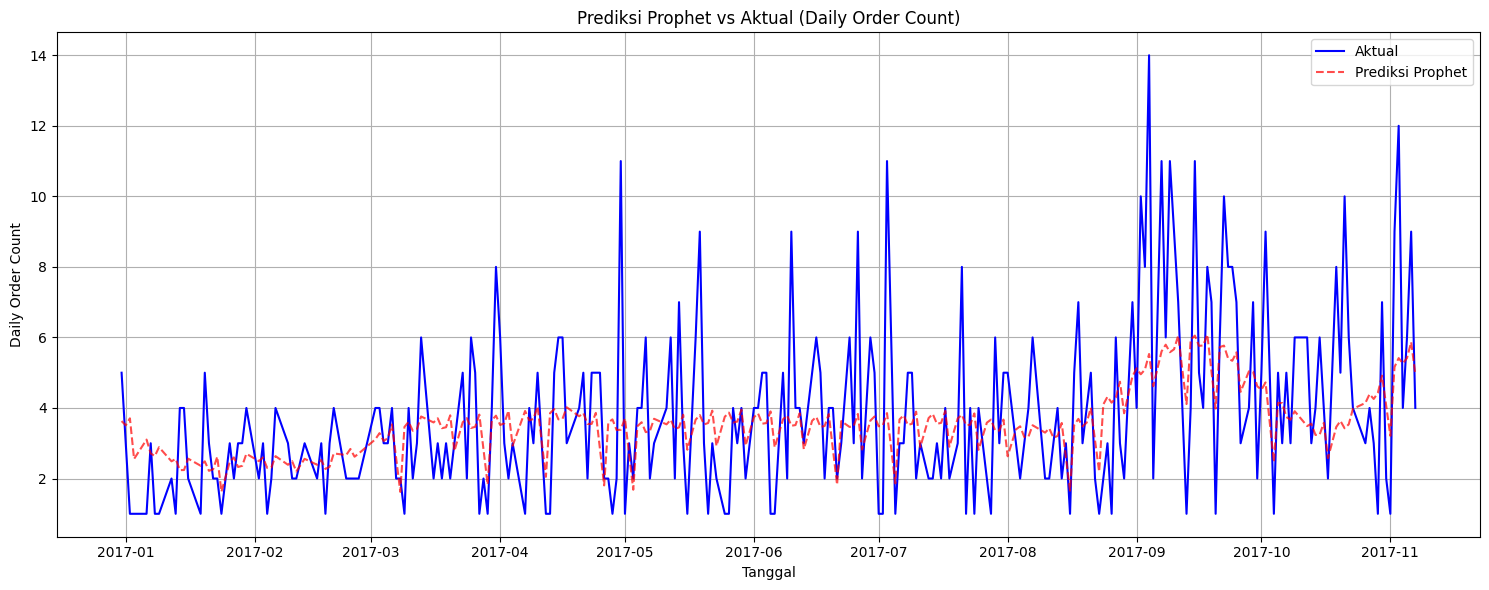

In [ ]:
# Prophet
df_prophet_orders = df_features[['daily_order_count']].reset_index().rename(columns={
    'Order Date': 'ds', 'daily_order_count': 'y'
})
train_prophet_orders = df_prophet_orders[df_prophet_orders['ds'] <= split_date]
test_prophet_orders = df_prophet_orders[df_prophet_orders['ds'] > split_date]
prophet_model_orders = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model_orders.fit(train_prophet_orders)
future_orders = prophet_model_orders.make_future_dataframe(periods=len(test_prophet_orders))
forecast_orders = prophet_model_orders.predict(future_orders)
y_pred_prophet_orders = forecast_orders[forecast_orders['ds'] > split_date][['ds', 'yhat']].set_index('ds')['yhat']
y_true_orders, y_pred_prophet_orders = test_prophet_orders.set_index('ds')['y'].align(y_pred_prophet_orders, join='inner')
rmse, mae, mape = evaluate_model(y_true_orders, y_pred_prophet_orders, "Prophet (Orders)")
plot_predictions(y_true_orders, y_pred_prophet_orders, "Prophet", "Daily Order Count")
results_orders.append(['Prophet', rmse, mae, mape])

--- SARIMA (Orders) ---
RMSE: 2.9730
MAE : 2.5178
MAPE: 117.67%


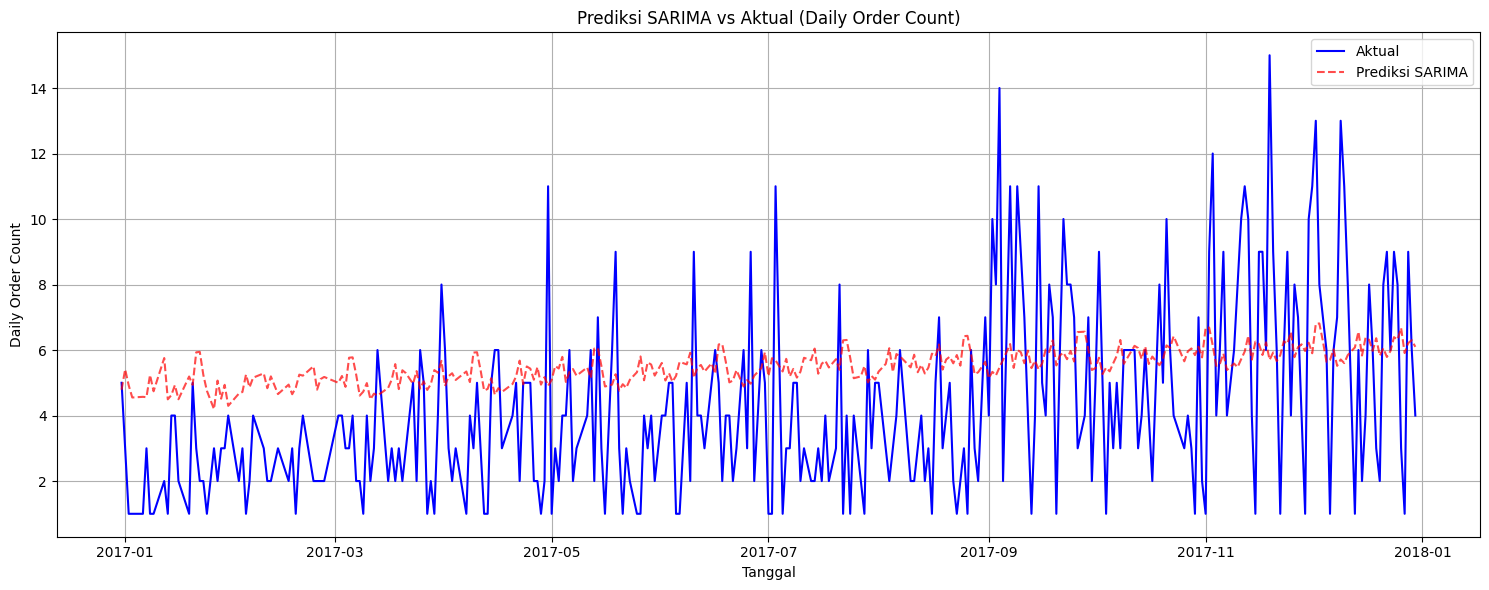

In [ ]:
# SARIMA Model
sarima_model_orders = SARIMAX(
    y_train_orders,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 30)
)

sarima_fit_orders = sarima_model_orders.fit(disp=False)

# Forecasting
# Get the forecast values as a numpy array and assign the y_test_orders index
y_pred_sarima_orders = pd.Series(sarima_fit_orders.forecast(steps=len(y_test_orders)).values, index=y_test_orders.index)

# ===== Perbaikan: Cek dan tangani NaN (Jika ada NaN setelah assigning index, fill here) =====
# Although unlikely after assigning index, keep this for robustness
y_pred_sarima_orders = y_pred_sarima_orders.fillna(0)

# Evaluasi - No need for align here as the index is already set
rmse, mae, mape = evaluate_model(y_test_orders, y_pred_sarima_orders, "SARIMA (Orders)")
plot_predictions(y_test_orders, y_pred_sarima_orders, "SARIMA", "Daily Order Count")

results_orders.append([
    'SARIMA',
    rmse, mae, mape
])

--- XGBoost (Orders) ---
RMSE: 1.3308
MAE : 0.9920
MAPE: 29.20%


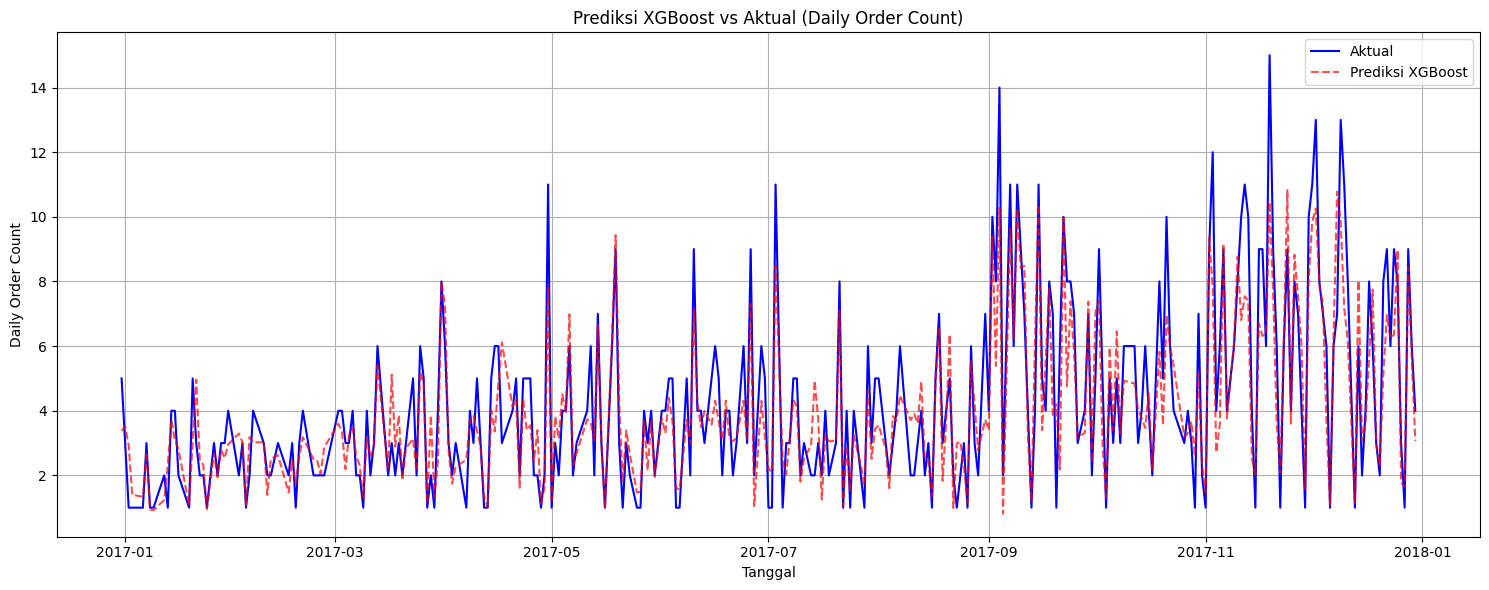

In [ ]:
# Model XGBoost
xgb_model_orders = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Training
xgb_model_orders.fit(X_train_ml, y_train_orders)

# Prediksi
y_pred_xgb_orders = xgb_model_orders.predict(X_test_ml)

# Evaluasi dan Visualisasi
rmse, mae, mape = evaluate_model(y_test_orders, y_pred_xgb_orders, "XGBoost (Orders)")
plot_predictions(y_test_orders, y_pred_xgb_orders, "XGBoost", "Daily Order Count")

results_orders.append([
    'XGBoost',
    rmse, mae, mape
])


# 14. Perbandingan Model

In [ ]:
results_sales_df = pd.DataFrame(results_sales, columns=['Model', 'RMSE', 'MAE', 'MAPE'])
print("\n--- Perbandingan Model (Daily Sales) ---")
print(results_sales_df.sort_values(by='MAPE'))


--- Perbandingan Model (Daily Sales) ---
          Model         RMSE          MAE         MAPE
1  Holt-Winters  2832.886206  1873.952875   292.482710
2      LightGBM  1668.819143  1128.088406   305.122852
5       XGBoost  1829.807989  1201.501927   308.558711
3       Prophet  1988.818435  1314.058972   542.747056
0         Naive  2914.810400  2027.033291   880.919014
4  ARIMA(1,1,1)  2166.919313  1647.736199  1023.785544


In [ ]:
results_orders_df = pd.DataFrame(results_orders, columns=['Model', 'RMSE', 'MAE', 'MAPE'])
print("\n--- Perbandingan Model (Daily Order Count) ---")
print(results_orders_df.sort_values(by='MAPE'))


--- Perbandingan Model (Daily Order Count) ---
            Model      RMSE       MAE        MAPE
7         XGBoost  1.330810  0.992047   29.197365
3  Tuned LightGBM  1.332152  1.000949   31.034249
2        LightGBM  1.353682  1.018817   33.240638
4         Prophet  2.107881  1.588268   60.384310
0           Naive  3.322880  2.543131   87.752773
1    Holt-Winters  2.950519  2.481884  111.524009
5          SARIMA  2.973038  2.517780  117.671548
6         XGBoost  2.973038  2.517780  117.671548
8          SARIMA  2.973038  2.517780  117.671548


**Interpretasi:**

- **XGBoost** menjadi model dengan performa terbaik, menghasilkan **MAPE terendah sebesar 29.20%**, yang menunjukkan kemampuannya dalam menangkap pola order harian secara lebih efektif dibandingkan model lainnya.
- **Tuned LightGBM** dan **LightGBM** juga memberikan hasil yang kompetitif, masing-masing dengan **MAPE sebesar 31.03%** dan **33.24%**, menegaskan bahwa model ensemble seperti LightGBM tetap sangat andal dalam memprediksi jumlah pesanan harian.
- **Prophet** tampil lebih baik dibandingkan model time series klasik seperti Holt-Winters dan Naive, dengan **MAPE sebesar 60.38%**, namun masih tertinggal jauh dari performa model berbasis machine learning.
- **Naive**, **Holt-Winters**, dan **SARIMA** menunjukkan performa yang kurang baik, dengan **MAPE mendekati atau melebihi 100%**, yang mengindikasikan bahwa pola order harian bersifat sangat fluktuatif dan tidak dapat ditangkap dengan baik oleh model time series tradisional.

# 15. Insight Bisnis dan Rekomendasi

### Laporan Analisis dan Temuan Utama
- **Total Revenue (2017)**: \$586,394.42  
- **Total Orders (2017)**: 1,341  
- **Total Quantity Sold (2017)**: 10,085 unit  
- **Rata-rata Barang per Transaksi (2017)**: 7.52  
- **Rata-rata Spending per Transaksi (2017)**: \$437.28  
- **Penjualan tertinggi** cenderung terjadi pada bulan: `{2014: 11, 2015: 12, 2016: 12, 2017: 11}`, kemungkinan karena musim liburan.
- **Penjualan terendah** terjadi pada bulan: `{2014: 2, 2015: 1, 2016: 2, 2017: 2}`, menunjukkan peluang untuk promosi khusus di awal tahun.
- **Top 5 kota dengan jumlah order terbanyak**:
  - New York City
  - Los Angeles
  - Philadelphia
  - San Francisco
  - Seattle
- **Top 5 kota dengan total spending terbesar**:
  - New York City
  - Los Angeles
  - San Francisco
  - Philadelphia
  - Seattle
- **Produk dengan revenue tertinggi dalam 3 bulan terakhir**:
  - Canon imageCLASS 2200 Advanced Copier
  - Cubify CubeX 3D Printer Triple Head Print
  - 3D Systems Cube Printer, 2nd Generation, Magenta
- **Model terbaik untuk prediksi Daily Sales** (berdasarkan MAPE): **Holt-Winters**
- **Model terbaik untuk prediksi Daily Order Count** (berdasarkan MAPE): **XGBoost**

---

### Rekomendasi Bisnis

- Lakukan **promosi khusus atau diskon** pada bulan-bulan dengan penjualan rendah seperti: `{2014: 2, 2015: 1, 2016: 2, 2017: 2}` untuk mendorong peningkatan penjualan di awal tahun.
- Terapkan strategi **bundling produk populer** berikut untuk meningkatkan GMV:
  - `'Eldon Image Series Desk Accessories, Burgundy'` + `'Memorex Micro Travel Drive 16 GB'`
  - `'Wirebound Four 2-3/4 x 5 Forms per Page, 400 Sets per Book'` + `'Memorex Micro Travel Drive 16 GB'`
- Fokuskan **kampanye iklan dan pemasaran** di kota-kota dengan pengeluaran besar seperti:
  - New York City
  - Los Angeles
- Gunakan **model LightGBM** untuk memprediksi:
  - **Daily Sales** (penjualan harian)
  - **Daily Order Count** (jumlah transaksi harian)